In [1]:
%autosave 50000

Autosaving every 50000 seconds


In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import pymc3 as pm 
import os 

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
from scipy import stats
from pymc3.distributions import draw_values
from pymc3.distributions import generate_samples
from pymc3.theanof import floatX
from pymc3.distributions.dist_math import bound
from pymc3.distributions import (Continuous, draw_values, generate_samples)

def assert_negative_support(var, label, distname, value=-1e-6):
    # Checks for evidence of positive support for a variable
    if var is None:
        return
    try:
        # Transformed distribution
        support = np.isfinite(var.transformed.distribution.dist
                              .logp(value).tag.test_value)
    except AttributeError:
        try:
            # Untransformed distribution
            support = np.isfinite(var.distribution.logp(value).tag.test_value)
        except AttributeError:
            # Otherwise no direct evidence of non-positive support
            support = False

    if np.any(support):
        msg = "The variable specified for {0} has negative support for {1}, ".format(
            label, distname)
        msg += "likely making it unsuitable for this parameter."
        warnings.warn(msg)

def get_tau_sigma(tau=None, sigma=None):
    if tau is None:
        if sigma is None:
            sigma = 1.
            tau = 1.
        else:
            tau = sigma**-2.
    else:
        if sigma is not None:
            raise ValueError("Can't pass both tau and sigma")
        else:
            sigma = tau**-.5
    tau = 1. * tau
    sigma = 1. * sigma
    return floatX(tau), floatX(sigma)

In [4]:
class weighted_Normal(pm.distributions.Continuous):

    def __init__(self, mu=0, sigma=None, tau=None, sd=None, weight =None,**kwargs):
        if sd is not None:
            sigma = sd
        tau, sigma = get_tau_sigma(tau=tau, sigma=sigma)
        self.sigma = self.sd = tt.as_tensor_variable(sigma)
        self.tau = tt.as_tensor_variable(tau)
        self.weight = tt.as_tensor_variable(weight)

        self.mean = self.median = self.mode = self.mu = mu = tt.as_tensor_variable(floatX(mu))
        self.variance = 1. / self.tau

        assert_negative_support(sigma, 'sigma', 'Normal')
        assert_negative_support(tau, 'tau', 'Normal')

        super().__init__(**kwargs)

    def random(self, point=None, size=None):
        
        mu, tau, _ = draw_values([self.mu, self.tau, self.sigma],
                                 point=point, size=size)
        return generate_samples(stats.norm.rvs, loc=mu, scale=tau**-0.5,
                                dist_shape=self.shape,
                                size=size)

    def logp(self, value):
        """
        Sum of Squares
        
        """
        sigma = self.sigma
        tau = self.tau
        mu = self.mu
        weight = self.weight
        
        logp =  weight * -  tt.sqr(value - mu)/(2.0 * sigma * sigma)
        return   logp.sum()


In [5]:
# DATA 
import pandas as pd
cwd = os.chdir('/Users/jackcarter/Blind_Mixture_Data')
dfx = pd.read_csv("jc_unmix_4_data_yz.csv")

In [6]:
# Ar39 
ar39 = dfx['Ar39_'].values

# Age 
age = dfx['Age'].values
data = age
age_err = dfx['Age_Er'].values
age_m = age
N = age.shape[0]
age = data[data > 0]

In [7]:
# Part 1 ThermoCouple T Calibration 
## Step 1: Pyrometer Calibration
import os 
cwd = os.getcwd()
os.chdir("/Users/jackcarter/Desktop/Downloads")
df1 = pd.read_csv("PyroApril2018.csv")
x2  = df1['Pyro'].values
x1 = df1['Thermo'].values
zpt = np.polyfit(x1,x2,3)

In [8]:
dfx.head()

,Ar40_,Ar40_Er,Ar39_,Ar39_Er,Pwr_Achieved,Dur_Heating_At_Req_Pwr,Age,Age_Er,temp,temp_err,time,Da2,Da2_err
0,0.010265,0.00016,0.000111,0.000022,360,3000,619.3026,557.51530,360.120,5.040,2996.968,8.960000e-14,1.190000e-14
1,0.002775,0.00011,0.000047,0.000022,360,3000,143.5513,1254.08500,359.880,4.980,2996.464,9.090000e-14,6.120000e-11
2,0.010492,0.00015,0.000347,0.000020,390,3000,510.0362,192.64900,389.860,3.361,2996.541,1.670000e-12,9.530000e-11
3,0.007350,0.00015,0.000298,0.000020,390,3000,431.3639,257.81230,389.910,3.227,2996.533,2.830000e-12,2.600000e-11
4,0.027919,0.00025,0.001101,0.000023,420,3000,184.7261,85.26751,419.992,2.620,2997.042,2.170000e-11,2.990000e-11


In [9]:
# DATA 
import pandas as pd

"""
Temp and Time
"""
time = dfx['time'].values
temp1 = dfx['temp'].values

da2 = dfx['Da2'].values
da2_err = dfx['Da2_err'].values

temp = np.polyval(zpt, temp1)
tempk = temp + 273.15


In [10]:
sns.set_style('ticks')
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

In [11]:
def cumrel(x): 
    y = np.cumsum(x)
    z = y/y.max()
    return z

In [12]:
ar39 = cumrel(ar39)
age = age
age_err = age_err
data3 = ar39

In [13]:
# Plotting parameters

age_plot = np.insert(age,
                     0, age[0])
age_plot_err =  np.insert(age_err, 
                         0, age_err[0])
ar39_plot = np.insert(ar39,
                      0, 0)

In [14]:
tplot = 1e4/tempk
arr_err = da2_err/da2

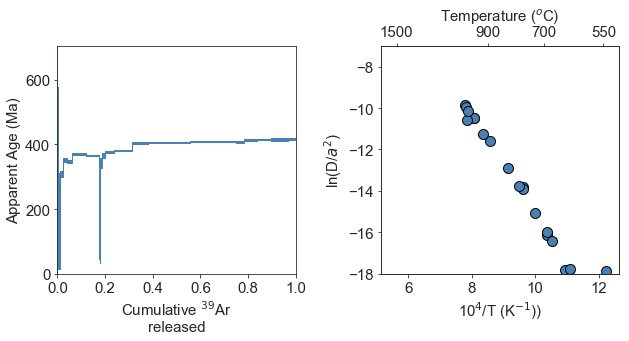

In [15]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)
sns.set_style('ticks')

fig, ax = plt.subplots(1,2, figsize= (9,5))
ax[0].fill_between(ar39_plot, 
                age_plot + 2*age_plot_err, 
                age_plot - 2*age_plot_err, 
                color = 'steelblue', 
                step = 'pre')

ax[0].set_ylim(0, 705)
ax[0].set_xlim(0,1)

ax[0].set_ylabel('Apparent Age (Ma)')
ax[0].set_xlabel('Cumulative $^{39}$Ar\nreleased');


ax[1].errorbar(tplot[1:N], np.log(da2[1:N]), yerr = arr_err[1:N],
              fmt = 'o', 
        markersize = 10, 
        markerfacecolor = 'steelblue', 
        markeredgecolor = 'k')


ax2 = ax[1].twiny()

Tdc = np.array([550,  700, 900,  1500])
Tp = 10e3/(Tdc + 273.15)
labels = list(['550', '700', '900',   
              '1500'])
ax2.plot(tplot, np.log(da2), alpha = 0)
ax2.set_xlabel('Temperature ($^{o}$C)')
ax[1].set_xlim(Tp.min() - 0.5, Tp.max()+ 0.5)
ax2.set_xlim(Tp.min() - 0.5, Tp.max()+ 0.5)

ax2.set_xlabel('Temperature ($^{o}$C)')
ax2.set_xticks(Tp)
ax2.set_xticklabels(labels)

ax[1].set_xlabel('10$^{4}$/T (K$^{-1}$))')
ax[1].set_ylabel('ln(D/$a^{2}$)')
ax[1].set_ylim(-18, -7)
plt.tight_layout()



In [16]:
def inc_mdd(ea, d0, a,phi,temp, t):
    R = 8.314e-3
    D0t = ((phi/a)**2)* d0 * np.exp(-ea/(R*temp))*t
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    aa1 = np.sqrt(np.pi) * a**2 * R * temp**2
    bb1 = (phi/a)**2 * d0*np.exp(-ea/(R*temp))*t
    dd1 = 3 * d0 * ea * t * phi**2
    z1 = (dd1 * np.exp(-ea/(R*temp)))/(aa1 * np.sqrt(bb1))
    aa2 = a**2 * R *temp**2
    bb2 = (phi/a)**2 * d0*np.exp(-ea/(R*temp))*t
    cc1 = 3 * d0 * ea * t * phi**2 * np.exp(-ea/(R*temp))
    z2 = cc1/(np.sqrt(np.pi) * aa2 * np.sqrt(bb2)) - cc1/(aa2) 
    aa3 = a**2 * R * temp**2
    bb3 = (phi/a)**2 * d0*np.exp(-ea/(R*temp))*t
    cc2 = 6 * d0 * ea * t * phi**2
    z3 = (cc2 * np.exp(-(np.pi**2 * bb3) - (ea/(R*temp)))/(aa3))
    Q = tt.switch(q <= 0.9,
                z2,
                 z3)
    T = tt.switch(q < 0.1, 
                  z1,
                  Q)
    return T

In [17]:
data = age
arr_data = np.log(da2)
arr_data
tempk;
arr_err = da2_err/da2

In [18]:
from theano import shared
err_age = shared(age_err)
t_obs = time
tempk = tempk
data = data
N = data.shape[0]

In [19]:
N

33

In [20]:
"""
Create Theano shared Variables
"""
age_err_data = shared(age_err[:N])
arr_err_data = shared(da2_err[:N]/da2[:N])
age_data = shared(data)
arrh_data = shared(arr_data)



In [228]:
"""
Stick Breaking 
"""
import pymc3.distributions.transforms as tr
from theano import tensor as tt
def stick_break(beta): 
    pr = tt.concatenate([[1], 
                         tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * pr


In [247]:
"""
Number of Components 
and Domains
"""
k = 20
m = 10
N = N

"""
Model Start
"""
Q = pm.Model()
with Q: 
    """
    Number of Components
    """
    alpha = pm.Gamma('alpha', 
                         1., 1.)

    beta = pm.Beta('beta', 1., alpha, 
                      shape = k, 
                  testval = 0.9)

    K_w = stick_break(beta)
    
    K = pm.Deterministic('K', 
                        K_w/K_w.sum(axis = 0,
                                    keepdims = True))
    
    C = pm.Categorical('C', 
                       p = K,
                       shape = (N,))
    
    """
    Number of Domains
    """
    phi = pm.Dirichlet('phi', 
                      np.linspace(1, 1e-10, m), 
                      shape = (k,m))
    
    D = pm.Categorical('D', 
                       p = phi[C], 
                       shape = N)

/Applications/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [248]:
with Q: 
    """
    Diffusion Kinetics
    - Activation energy 
    - Frequency Factor
    - With Hyperparameters
    """
    ea_mean = pm.Uniform('ea_mean',
                      lower = 80, 
                      upper = 500, 
                      shape = k, 
                        testval = 200)
    
    ea_sd = pm.HalfNormal('ea_sd',
                      sd = ea_mean/10, 
                      shape = k)
    
    ea = pm.Normal('ea',
                      mu = ea_mean, 
                      sd = ea_sd, 
                      shape = k)
    
    d0_mean = pm.Uniform('d0_mean',  
                      lower = 0.0, 
                      upper = 10000,
                      shape = k, 
                        testval = 30)
    
    d0_sd = pm.HalfNormal('d0_sd',  
                      sd = d0_mean/10, 
                      shape = k)
        
        
    d0 = pm.Normal('d0',  
                      mu = d0_mean, 
                      sd = d0_sd,
                      shape = k)

    pm.Potential('diff_kin_con', 
                tt.switch(ea < 80, 
                         -np.inf, 0)+ 
                tt.switch(ea > 500, 
                         -np.inf, 0) + 
                tt.switch(d0 < 0, 
                         -np.inf, 0) + 
                tt.switch(d0 > 10000, 
                         -np.inf, 0))


In [249]:
import pymc3.distributions.transforms as tr
with Q: 
    """
    Grain size and/or domain size
    """
    a = pm.Uniform('a', lower = 0.00001, 
                  upper = 0.025, 
                  shape = (k,m))

In [250]:
with Q: 
    """
    Age Prior
    """
    age_mean = pm.Uniform('age_mean',
                              lower = 0,
                              upper = 4600,
                              shape = k, 
                          testval = data.mean()
                         )
    
    age_sd = pm.HalfNormal('age_sd', 
                          sd = age_mean/10,
                          shape = k)
    
    age_model = pm.Normal('age_model', mu = age_mean, 
                         sd = age_sd, 
                         shape = k)
    
    pm.Potential('age_con', 
                tt.switch(age_model < 0, 
                         -np.inf, 0) + 
                tt.switch(age_model > 4600, 
                         -np.inf, 0))

In [251]:
with Q: 
    """
    Indexing everything 
    for the trace
    """
    age_comp = pm.Deterministic('age_comp',
                                age_model[C])
    ea_comp = pm.Deterministic('ea_comp',
                               ea[C])
    d0_comp = pm.Deterministic('d0_comp',
                               d0[C])
    phi_comp = pm.Deterministic('phi_comp',
                                K[C])
    a_domain = pm.Deterministic("a_domain",
                                a[C,D])
    phi_domain = pm.Deterministic('phi_domain',
                                  phi[C,D])

/Applications/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [252]:
with Q:
    """
    Age Spectra Model
    """
    Z2 = K[C] * inc_mdd(ea[C], 
                d0[C], 
                a[C,D], 
                phi[C,D],
                tempk[:,None],
                t_obs[:,None])
    
    Y_sum2 = Z2.sum(axis = 1)
    
    XX = (Z2 * age_model[C]).sum(axis = 1)

    mu2 = (XX/Y_sum2)
    

/Applications/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [253]:
with Q: 
    """
    Incremental Release Trace
    """
    inc_rel = pm.Deterministic('inc_rel', Y_sum2)

In [254]:
with Q:
    """
    Arrhenius Model
    """
    R = 8.314e-3
    
    yy2 = ((phi[C,D]/a[C,D])**2) \
                 * (d0[C] * np.exp(-ea[C]/(R*tempk)))
    
    y2 = K[C] * yy2
    mu1 = tt.log(y2)

/Applications/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


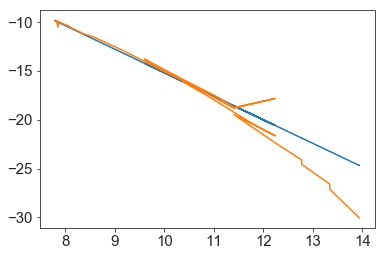

In [255]:
plt.plot(tplot[:N], mu1.tag.test_value[:N])
plt.plot(tplot[:N], np.log(da2[:N]))

# Weights and Likelihood

In [256]:
"""
Calculate Model weights
"""
def logp_w(data, model, err): 
    y =   - ((data - model)**2)/(2*err * err)
    return y.sum()

y1_test = mu2.tag.test_value
y2_test = mu1.tag.test_value

with Q: 

    y1 = logp_w(data[:N], 
                y1_test[:N],
                age_err[:N])
    
    y2 = logp_w(arr_data[0:N-1], 
               y2_test[0:N-1],
                arr_err_data[0:N-1])

    
    weight = y1/y2
    

In [257]:
1/weight.eval()

5597.719218957236

In [258]:
with Q: 
    """
    Arrhenius Likelihood
    """
    obs2 = weighted_Normal('obs2', mu = mu1[:N-1],
                     sd = arr_err_data[:N-1], 
                     observed = arrh_data[:N-1], 
                          weight = weight)

In [259]:
with Q: 
    """
    Age Likelihood
    """
    obs1 = weighted_Normal('obs1', mu = mu2[:N], 
                           sd = age_err_data[:N], 
                           observed = age_data[:N], 
                          weight = 1)

In [260]:
Q.check_test_point()

/Applications/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


alpha_log__               -1.00
beta_logodds__           -48.16
C                         -3.48
phi_stickbreaking__     -422.70
D                        -53.11
ea_mean_interval__       -31.78
ea_sd_log__              -15.40
ea                       -73.78
d0_mean_interval__      -116.24
d0_sd_log__              -15.40
d0                       -35.84
a_interval__            -277.26
age_mean_interval__      -53.73
age_sd_log__             -15.40
age_model                -84.28
obs2                  -18490.73
obs1                  -18490.73
Name: Log-probability of test_point, dtype: float64

In [286]:
SAMPLES = 5000
BURN = 100000
SEED = np.random.seed(123)

with Q:
    step1 = pm.CategoricalGibbsMetropolis([C,D]) 

    
    step2 = pm.Metropolis([age_mean, age_sd,
                           ea, d0, 
                           d0_sd, d0_mean,
                           ea_mean, ea_sd,
                           age_model, 
                           phi, a], 
                         scaling = 100)
    
    step3 = pm.Metropolis([alpha, beta])
            
    trace = pm.sample(SAMPLES, tune = BURN, 
                     step = [step1,
                             step2,
                             step3],
                     random_seed = SEED)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CategoricalGibbsMetropolis: [D, C]
>CompoundStep
>>Metropolis: [a]
>>Metropolis: [phi]
>>Metropolis: [age_model]
>>Metropolis: [ea_sd]
>>Metropolis: [ea_mean]
>>Metropolis: [d0_mean]
>>Metropolis: [d0_sd]
>>Metropolis: [d0]
>>Metropolis: [ea]
>>Metropolis: [age_sd]
>>Metropolis: [age_mean]
>CompoundStep
>>Metropolis: [beta]
>>Metropolis: [alpha]
/Applications/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sampling 2 chains: 100%|██████████| 210000/210000 [1:35:35<00:00, 36.61draws/s]  
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated nu

/Applications/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Text(0, 0.5, 'Log probability')

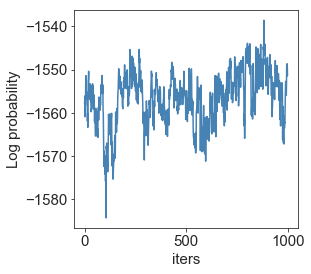

In [287]:
"""
Trace of Logp
"""
SAMPLES = 1000
logp_model = Q.logp
logp = [logp_model(i) for i in trace[-SAMPLES:]]
logp_x = np.array([logp])
logp_x = logp_x.reshape(SAMPLES)

"""
Plot
"""
plt.figure(figsize = (4,4))
plt.plot(logp_x,
        color = 'steelblue')
plt.xlabel('iters')
plt.ylabel('Log probability')

/Applications/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


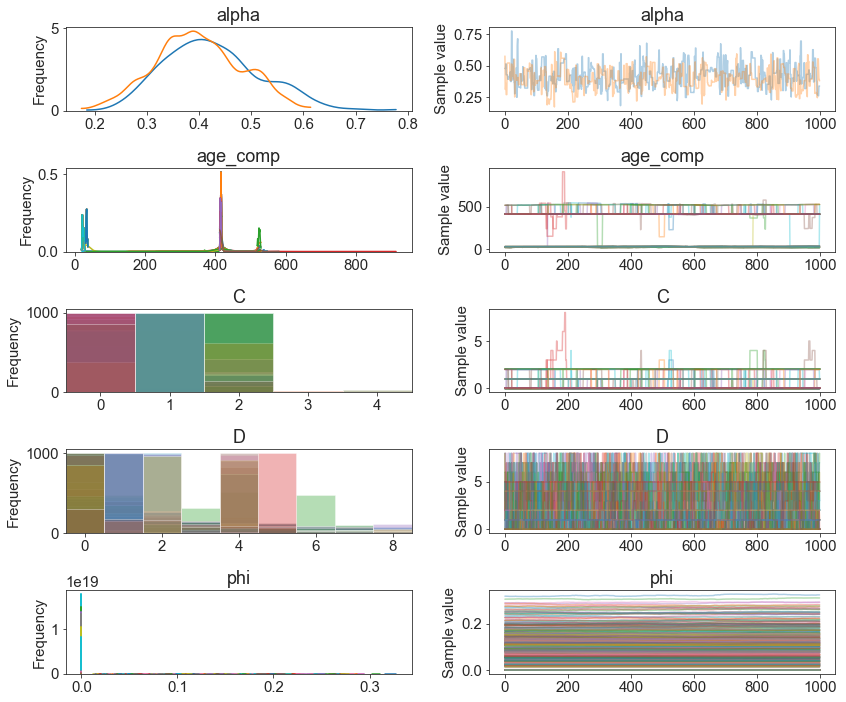

In [288]:
pm.traceplot(trace[-1000:], varnames =  [alpha, 
                             age_comp, 
                             C, 
                             D, 
                             phi]); 

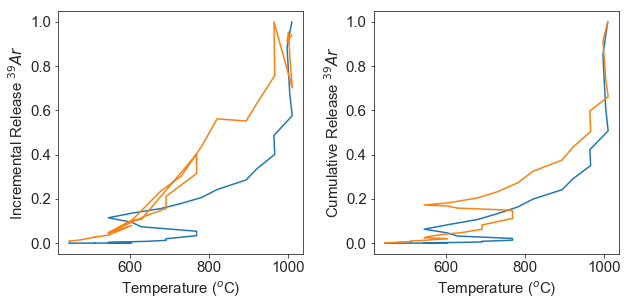

In [289]:
fig, ax = plt.subplots(1,2, figsize = (9, 4.5))

ax[0].plot(temp[:N],
ar39[:N]/ar39[:N].max())

ax[0].plot(temp, 
trace['inc_rel'].mean(axis=0)/trace['inc_rel'].mean(axis=0).max())
ax[1].plot(temp[:N], 
          cumrel(ar39[:N]))
ax[1].plot(temp,
          cumrel(trace['inc_rel'].mean(axis=0)))
ax[0].set_xlabel('Temperature ($^{o}$C)')
ax[1].set_xlabel('Temperature ($^{o}$C)')
ax[0].set_ylabel('Incremental Release $^{39}Ar$')
ax[1].set_ylabel('Cumulative Release $^{39}Ar$')

plt.tight_layout()

In [290]:
SAMPLES = 5000

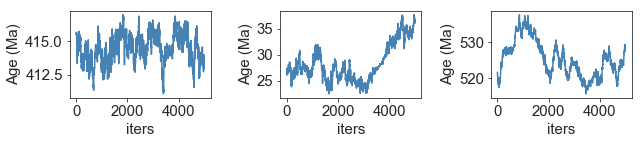

In [306]:
n_comp = np.apply_along_axis(lambda x: np.unique(x).size, 
                            1, trace['C'][-SAMPLES::10])

n_comp =  n_comp 
ncmp = n_comp.mean(axis = 0).astype(int)
plt.figure(figsize = (ncmp*3, ncmp*0.75))
for i in range(ncmp):
    plt.subplot(1,ncmp,i+1)
    plt.plot(trace['age_model'][-SAMPLES:][:,i],
        color = 'steelblue')

    plt.xlabel('iters')
    plt.ylabel('Age (Ma)')

plt.tight_layout()

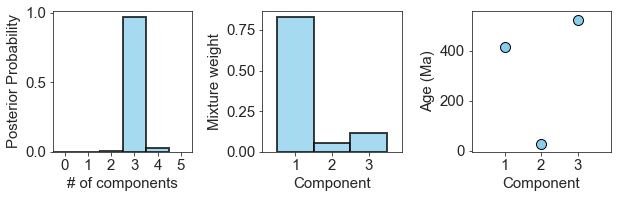

In [307]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

fig, ax = plt.subplots(1, 3, figsize = (9, 3))
n_comp = np.apply_along_axis(lambda x: np.unique(x).size, 
                            1, trace['C'][-SAMPLES::10])

n_comp =  n_comp 
ncmp = n_comp.mean(axis = 0).astype(int)
bins = np.arange(n_comp.min() -2 , n_comp.max() + 2)

ax[0].hist(n_comp,
        bins=bins,
        density=True,
        lw= 2,
        alpha=0.75, 
       edgecolor = 'k', 
        facecolor = 'skyblue');

ax[0].set_xticks(bins + 0.5);
ax[0].set_xticklabels(bins);
ax[0].set_xlim(bins.min(),bins.max() + 1);
ax[0].set_xlabel('# of components');



plot_w = np.arange(ncmp) + 1

ax[1].bar(plot_w - 0, trace['K'][-SAMPLES::10].mean(axis=0)[:ncmp],
          width=1., lw=2, 
      edgecolor = 'k', alpha = 0.75, 
         facecolor = 'skyblue');

ax[1].set_xlabel('Component');

ax[1].set_ylabel('Mixture weight');

ax[1].locator_params(axis='x', nbins=12)

ax[2].errorbar(np.linspace(1, ncmp,ncmp).astype(int),
             trace['age_model'][-SAMPLES::10].mean(axis = 0)[:ncmp], 
             yerr = 2*trace['age_model'][-SAMPLES::10].std(axis = 0)[:ncmp], 
             fmt ='o', 
             markersize = 10, 
             markeredgecolor = 'k', 
             markerfacecolor = 'skyblue')

ax[2].set_xlabel('Component');

ax[2].set_ylabel('Age (Ma)');
ax[0].set_ylabel('Posterior Probability')

ax[2].locator_params(axis='x', nbins=ncmp + 1)
ax[2].locator_params(axis='y', nbins=ncmp + 1)
ax[2].set_xlim(0.1, ncmp + 0.9)
ax[1].set_xlim(0.1, ncmp + 0.9)
ax[1].locator_params(axis='x', nbins=ncmp + 1)

plt.tight_layout()



In [309]:
np.set_printoptions(suppress=True)
print(trace['age_model'][-SAMPLES::10].mean(axis = 0).round(3))


[414.445  28.193 525.289 158.636 579.171 188.137 150.259 323.959 192.
 437.357 345.811  30.41  462.492 279.956 568.557 790.769 193.605  59.442
 257.335 272.233]


In [310]:
trace['age_model'][-SAMPLES::10].std(axis = 0).round(3)

array([ 1.045,  3.511,  4.958,  7.54 ,  3.77 ,  8.36 ,  4.941,  5.215,
        2.986,  6.954, 10.814,  2.321,  2.476,  5.274,  3.833,  3.738,
        7.138,  4.781,  7.21 , 11.567])

In [311]:
trace['ea'].mean(axis = 0).round(2)

array([200.84, 184.24, 180.91, 205.74, 190.42, 201.62, 197.64, 206.32,
       202.19, 203.19, 199.24, 202.64, 199.27, 206.04, 194.34, 196.67,
       190.18, 209.38, 221.64, 215.67])

In [297]:
from scipy import stats
with Q: 
    ppc = pm.sample_ppc(trace,
                        1000)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  after removing the cwd from sys.path.
  0%|          | 0/1000 [00:00<?, ?it/s]/Applications/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
100%|██████████| 1000/1000 [00:45<00:00, 28.38it/s]


In [298]:
# Mean Predictive Models
Z2 = ppc['obs1'].mean(axis = 0)
low2, high2 = np.percentile(ppc['obs1'], 
                            [50 - 34, 50 + 34], 
                            axis = 0)

# Frel_model
inc_model = trace['inc_rel'].mean(axis = 0)
frel_model = cumrel(inc_model)

In [299]:
sns.set_style('ticks')
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

# Plotting parameters 
ar39 = cumrel(ar39[:37])

low2_plot = np.insert(low2, 0, low2[0])
high2_plot = np.insert(high2, 0, high2[0])
z2_plot = np.insert(Z2, 0, Z2[0])
frel_model_plot = np.insert(frel_model, 0, 0)

data2_plot = np.insert(ar39, 0, 0)
data_plot = np.insert(data, 0, data[0])
age_err_plot = np.insert(age_err, 0, age_err[0])


In [300]:
def arr_plot(ea, d0, a, temp): 
    R = 8.314e-3
    da2 = (d0/a.max()**2) * np.exp(-ea/(R*temp))
    
    return np.log(da2)

In [301]:
tplot = 10000/tempk

# Mean Predictive Models
Z1 = ppc['obs2'].mean(axis = 0)
low1, high1 = np.percentile(ppc['obs2'], [50 - 34, 50 + 34], axis = 0)

(0, 500)

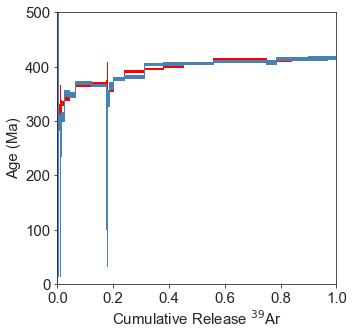

In [302]:
sns.set_style('ticks')

font= {"family": "Arial", 
      "weight": "normal",
      "size":15}

plt.rc("font", **font)

fig, ax = plt.subplots(1,1, figsize = (5, 5))

ax.fill_between(ar39_plot, low2_plot, 
                 high2_plot, 
                 alpha = 1, 
                color = 'r', 
                label = 'Model\n68%Credible\nInterval', 
                  step = 'pre', 
                  interpolate = True,  
                  lw = 1)


ax.fill_between(ar39_plot, 
                age_plot + 2*age_plot_err, 
                age_plot - 2*age_plot_err, 
                color = 'steelblue', 
                step = 'pre', 
                label = 'Data')

ax.set_xlabel('Cumulative Release $^{39}$Ar')
ax.set_ylabel('Age (Ma)')
ax.set_xlim(0, 1)
ax.set_ylim(0, 500)



/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


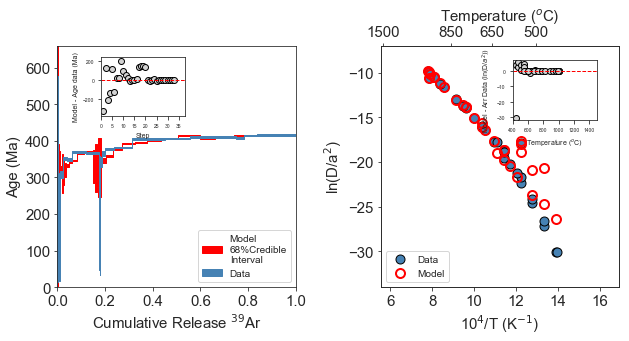

In [303]:
sns.set_style('ticks')

font= {"family": "Arial", 
      "weight": "normal",
      "size":15}

plt.rc("font", **font)


fig, ax = plt.subplots(1,2, figsize = (9, 5))

ax[0].fill_between(frel_model_plot, low2_plot, 
                 high2_plot, 
                 alpha = 1, 
                color = 'r', 
                label = 'Model\n68%Credible\nInterval', 
                  step = 'pre', 
                  interpolate = True,  
                  lw = 1)


ax[0].fill_between(ar39_plot, 
                age_plot + 2*age_plot_err, 
                age_plot - 2*age_plot_err, 
                color = 'steelblue', 
                step = 'pre', 
                label = 'Data')

ax[0].set_xlabel('Cumulative Release $^{39}$Ar')
ax[0].set_ylabel('Age (Ma)')




ax[1].plot(tplot[0:N-1], arr_data[0:N-1], 
          'o', markerfacecolor = 'steelblue', 
          markeredgecolor = 'k', 
          markersize = 9, label = 'Data')


ax[1].plot(tplot[0:N-1],Z1, 'or',
             markerfacecolor = 'None',
            alpha = 1, 
             markeredgecolor = 'r', markeredgewidth = 2, 
            markersize = 9, 
            label = 'Model')


#### Temp #####

ax2 = ax[1].twiny()

Tdc = np.array([500,  650, 850,  1500])
Tp = 10e3/(Tdc + 273.15)
labels = list(['500', '650', '850',   
              '1500'])
ax2.plot(tplot, arr_data, alpha = 0)
ax2.set_xlabel('Temperature ($^{o}$C)')
ax[1].set_xlim(Tp.min() - 0.1, Tp.max()+ 4)
ax2.set_xlim(Tp.min() -0.1, Tp.max()+ 4)

ax2.set_xticks(Tp)
ax2.set_xticklabels(labels)


ax3 =plt.axes([0.805,0.64,0.13,0.165])

ax3.plot(tempk[0:N-1] - 273.15, Z1 - arr_data[0:N-1],
         'ok', 
        markeredgecolor = 'k', 
        markerfacecolor = 'lightgrey')
qqq = Z1 - arr_data[0:N-1]
ax3.axhline(0, lw = 1, ls = '--', 
           color = 'r')
ax3.set_ylabel('Model - Arr Data (ln(D/$a^{2}$))', fontsize = 7)
ax3.set_xlabel('Temperature ($^{o}$C)', fontsize = 7)
ax3.set_ylim(qqq.min() - 1, qqq.max() + 1)
ax3.tick_params(labelsize = 5)
ax3.locator_params(axis='x', nbins=6)
ax3.set_xlim(400, 1500)

ax[1].set_xlabel('10$^{4}$/T (K$^{-1}$)')
ax[1].set_ylabel('ln(D/a$^{2}$)')
ax[1].locator_params(axis='y', nbins=6)
ax[1].locator_params(axis='x', nbins=6)


ax4 =plt.axes([0.17,0.65,0.13,0.165])

ax4.plot(np.linspace(1, N, N).astype(int), Z2 - data, 'ok', 
        markeredgecolor = 'k', 
        markerfacecolor = 'lightgrey')
qqq2 = Z2 - data
ax4.set_ylim(qqq2.min() - 50, qqq2.max() + 50)

ax4.axhline(0, lw = 1, ls = '--', 
           color = 'r')
ax4.set_ylabel('Model - Age data (Ma)', fontsize = 7)
ax4.set_xlabel('Step', fontsize = 7)
ax4.tick_params(labelsize = 5)
ax4.locator_params(axis='x', nbins=10)
ax4.set_xlim(0, N+5)
#ax[0].set_ylim(0, 300)
ax[0].set_xlim(0, 1)

ax[0].legend(loc = 4, fontsize = 10)
ax[1].legend(loc = 3, fontsize = 10)
ax[1].set_ylim(-34, -7)
ax[0].set_ylim(0, 660)

plt.tight_layout()


In [304]:
temp_plot = np.linspace(450, 1600, 20)
tplot_2 = 10000/temp_plot

# CDF

Text(0, 0.5, 'Cumulative density')

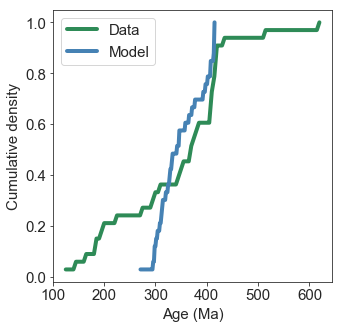

In [305]:
num_bins = 100 
counts, bin_edges = np.histogram(age, bins = num_bins, 
                                density = True)
cdf = np.cumsum(counts)

counts2, bin_edges2 = np.histogram(Z2, bins = num_bins, 
                                density = True)
cdf2 = np.cumsum(counts2)

plt.figure(figsize = (5,5))
plt.plot(bin_edges[1:], cdf/cdf[-1], 
        label = 'Data', 
        lw = 4,
        color = 'seagreen')
plt.plot(bin_edges2[1:], cdf2/cdf2[-1], 
        label = 'Model', 
        lw = 4, 
        color= 'steelblue')

plt.legend()
plt.xlabel('Age (Ma)')
plt.ylabel('Cumulative density')

# DataFrames for plotting


In [208]:
df_age = pd.DataFrame({"age_model": Z2,
                      "age_model_low": low2,
                      "age_model_high": high2, 
                      "frel_model": frel_model})

df_arr = pd.DataFrame({"arr_model": Z1,
                      "arr_model_low": low1,
                      "arr_model_high": high1})

df_age_comp = pd.DataFrame({"age1": trace['age_model'][:,0][-SAMPLES:],
                           "age2": trace['age_model'][:,1][-SAMPLES:],
                           "age3": trace['age_model'][:,2][-SAMPLES:],
                           "age4": trace['age_model'][:,3][-SAMPLES:],
                           "age5": trace['age_model'][:,4][-SAMPLES:],
                           "age6": trace['age_model'][:,5][-SAMPLES:],
                           "age7": trace['age_model'][:,6][-SAMPLES:]})

df_w_comp = pd.DataFrame({"w1": trace['K'][:,0][-SAMPLES:],
                           "w2": trace['K'][:,1][-SAMPLES:],
                           "w3": trace['K'][:,2][-SAMPLES:],
                           "w4": trace['K'][:,3][-SAMPLES:],
                           "w5": trace['K'][:,4][-SAMPLES:],
                           "w6": trace['K'][:,5][-SAMPLES:],
                           "w7": trace['K'][:,6][-SAMPLES:]})


df_ea = pd.DataFrame({"ea1": trace['ea'][:,0][-SAMPLES:],
                           "ea2": trace['ea'][:,1][-SAMPLES:],
                           "ea3": trace['ea'][:,2][-SAMPLES:],
                           "ea4": trace['ea'][:,3][-SAMPLES:]})



df_d0 = pd.DataFrame({"d01": trace['d0'][:,0][-SAMPLES:],
                           "d02": trace['d0'][:,1][-SAMPLES:],
                           "d03": trace['d0'][:,2][-SAMPLES:],
                           "d04": trace['d0'][:,3][-SAMPLES:]})


df_a = pd.DataFrame({"a1": trace['a'][:,0].mean().max(),
                    "a2": trace['a'][:,1].mean().max(),
                    "a3": trace['a'][:,2].mean().max()})



ValueError: If using all scalar values, you must pass an index

In [ ]:
df_age.to_csv("/Users/jackcarter/Blind_Mixtures/bm1_age.csv")
df_arr.to_csv("/Users/jackcarter/Blind_Mixtures/bm1_arr.csv")
df_age_comp.to_csv("/Users/jackcarter/Blind_Mixtures/bm1_age_comp.csv")
df_w_comp.to_csv("/Users/jackcarter/Blind_Mixtures/bm1_w_comp.csv")
df_ea.to_csv("/Users/jackcarter/Blind_Mixtures/bm1_ea_comp.csv")
df_d0.to_csv("/Users/jackcarter/Blind_Mixtures/bm1_d0_comp.csv")



In [ ]:
df_age.to_csv("/Users/jackcarter/Blind_Mixtures/bm4_age.csv")
df_arr.to_csv("/Users/jackcarter/Blind_Mixtures/bm4_arr.csv")
df_age_comp.to_csv("/Users/jackcarter/Blind_Mixtures/bm4_age_comp.csv")
df_w_comp.to_csv("/Users/jackcarter/Blind_Mixtures/bm4_w_comp.csv")
df_ea.to_csv("/Users/jackcarter/Blind_Mixtures/bm4_ea_comp.csv")
df_d0.to_csv("/Users/jackcarter/Blind_Mixtures/bm4_d0_comp.csv")

# 